## POSTPROECESSING

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install leidenalg==0.7.0

In [3]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

from MODULES.utilities import load_obj
import torch
import numpy
import skimage.color
import torch.nn.functional as F
from MODULES.graph_clustering import *
import time
from typing import List, Tuple

## Helper function

In [29]:
def show_sweep(suggestion: Suggestion,
               raw_image: numpy.ndarray,
               figsize: Tuple[int, int] = (12, 12),
               interval: int = 50,
               nbins=10,
               hist_range=(0,200)):
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)
    ax_video = axs[0,0]
    ax_image = axs[0,1]
    ax_graph = axs[1,0]
    ax_hist = axs[1,1]
    
    # image
    ax_video.axis('off')
    im = ax_video.imshow(skimage.color.label2rgb(suggestion.sweep_seg_mask[0, ...], bg_label=0), aspect='equal')
    ax_video.set_title("title")

    # reference image
    ax_image.axis('off')
    _ = ax_image.imshow(raw_image, cmap='gray', aspect='equal')
    
    # graph
    color = 'tab:red'
    _ = ax_graph.plot(suggestion.sweep_resolution, suggestion.sweep_n_cells, '.--', label="n_cell", color=color)
    ax_graph.set_xlabel("resolution")
    ax_graph.set_ylabel('n_cell', color=color)
    ax_graph.tick_params(axis='y', labelcolor=color)
    ax_graph.legend()
    ax_graph.grid()

    ax_graph_2 = ax_graph.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:green'
    _ = ax_graph_2.plot(suggestion.sweep_resolution, suggestion.sweep_iou, '-', label="iou", color=color)
    ax_graph_2.set_ylabel('iou', color=color)
    ax_graph_2.tick_params(axis='y', labelcolor=color)
    ax_graph_2.legend()
    
    # histogram of sizes (excluding background cluster)
    _ = ax_hist.hist(suggestion.sweep_sizes[0][1:], range=hist_range, density=False, bins=nbins)
    ax_hist.set_title("title")
        
    plt.tight_layout()
    plt.close()
    
    def init():
        im.set_data(suggestion.sweep_seg_mask[0, ...])
        ax_video.set_title("title")
        ax_hist.hist(suggestion.sweep_sizes[0][1:], range=hist_range, density=False, bins=nbins)
        
    def animate(i):
        title = 'frame={0:3d} res={1:.3f} ncell={2:2d}'.format(i,suggestion.sweep_resolution[i],
                                                                 suggestion.sweep_n_cells[i])
        ax_video.imshow(skimage.color.label2rgb(suggestion.sweep_seg_mask[i, ...], bg_label=0))
        ax_video.set_title(title)
        ax_hist.clear()
        ax_hist.hist(suggestion.sweep_sizes[i][1:], range=hist_range, density=False, bins=nbins)
        ax_hist.set_title("PDF cell size")
        
    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=suggestion.sweep_seg_mask.shape[0],
        interval=interval)
    
    return HTML(anim.to_html5_video())

In [5]:
def plot_overlay(seg_mask: numpy.ndarray, raw_image: numpy.ndarray, figsize: tuple = (24,24)):
    figure, ax = plt.subplots(ncols=3, figsize=figsize)
    ax[0].imshow(skimage.color.label2rgb(label=seg_mask, bg_label=0))
    ax[1].imshow(skimage.color.label2rgb(label=seg_mask, image=raw_image, alpha=0.25, bg_label=0))
    ax[2].imshow(raw_image, cmap='gray')

In [6]:
def plot_tiling(tiling: Segmentation, window: Optional[tuple] = None):
    
    if window is None:
        min_row, min_col, max_row, max_col = None, None, None, None
    else:
        min_row, min_col, max_row, max_col = window 
        
    fig, axs = plt.subplots(ncols=3, figsize=(24,24))

    axs[0].imshow(tiling.raw_image[0,0,min_row:max_row, min_col:max_col].cpu())
    axs[1].imshow(tiling.fg_prob[0,0,min_row:max_row, min_col:max_col].cpu())
    axs[2].imshow(skimage.color.label2rgb(tiling.integer_mask[0,0,min_row:max_row, min_col:max_col].cpu().numpy(), bg_label=0), aspect='equal')
    axs[0].set_title("raw image")
    axs[1].set_title("fg prob")
    axs[2].set_title("sample segmentation")

In [7]:
def plot_comparison(keys, dict1: dict, dict2: Optional[dict]=None, dict3: Optional[dict]=None, dict4: Optional[dict]=None):

    fig, axs = plt.subplots(figsize=(12,6))
    
    axs.plot(dict1["resolution_list"],dict1[keys], '-', label="dict1",color="blue")
    
    if dict2 is not None:
        axs.plot(dict2["resolution_list"],dict2[keys], 'x--', label="dict2",color="red")
    if dict3 is not None:
        axs.plot(dict3["resolution_list"],dict3[keys], 'o-', label="dict3",color="green") 
    if dict4 is not None:
        axs.plot(dict4["resolution_list"],dict4[keys], '.--', label="dict4",color="black")
    
    axs.set_xlabel('resolution parameter')
    axs.set_ylabel(keys)
    axs.grid()
    axs.legend()

# Import files

In [8]:
#tiling_file = "/home/jupyter/REPOS/spacetx-research/NEW_ARCHIVE/merfish_aug_5_v1/tiling_aug7_radius5.pt"
#tiling_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/merfish_aug_5_v1/tiling.pt"
#tiling_file = "NEW_ARCHIVE/merfish_aug_12_v2/tiling.pt"
#tiling_file = "NEW_ARCHIVE/merfish_segment_june27_v2/tiling.pt"
#tiling_file = "NEW_ARCHIVE/merfish_aug_12_v6/tiling.pt"
#tiling_file = "NEW_ARCHIVE/merfish_aug_17_v1/tiling_3100.pt"
tiling_file = "NEW_ARCHIVE/merfish_aug_17_v1/tiling_3100_LARGE.pt"

# Comparison of criteria using small images

In [9]:
tiling = load_obj(tiling_file)

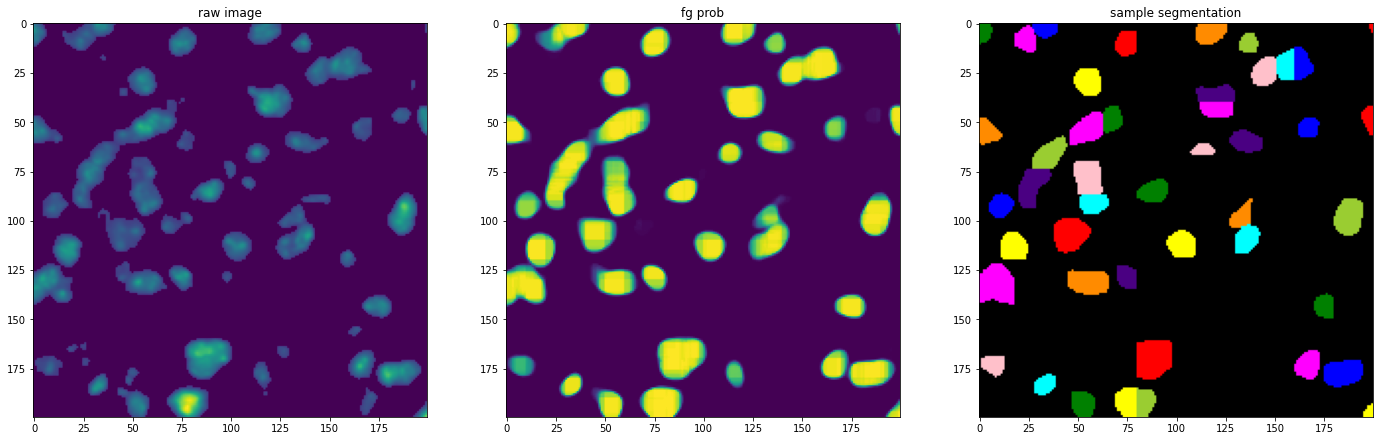

In [10]:
window = (1000, 2000, 1200, 2200)
#window = None
plot_tiling(tiling, window)

In [11]:
g = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.01, normalize_graph_edges=True)

cuda:0
cuda:0 torch.Size([37734451])
cuda:0 torch.Size([2, 37734451])
Done building the graph


In [33]:
sweep_modularity = g.suggest_resolution_parameter(window = window, 
                                                  min_size = 10,
                                                  max_size = None,
                                                  cpm_or_modularity = "modularity",
                                                  each_cc_separately = False,
                                                  sweep_range = numpy.arange(1.0,2.0,0.2)) 

b2
cuda:0 cuda:0
c2
resolution sweep,   1 out of   5
resolution sweep,   2 out of   5
resolution sweep,   3 out of   5
resolution sweep,   4 out of   5
resolution sweep,   5 out of   5


In [34]:
raw_image = tiling.raw_image[0,0,window[0]:window[2],window[1]:window[3]].cpu().numpy()
show_sweep(sweep_modularity, 
           raw_image,
           figsize=(12,12),
           interval=500, nbins=50, hist_range=(0,600))

In [ ]:
FROM HERE
FROM HERE

#sweep_modularity.show_best()

index=33
plot_overlay(seg_mask=suggestion.sweep_seg_mask[index], 
             raw_image=tiling_small.raw_image[0,0].cpu().numpy())

def plot_overlay(seg_mask: numpy.ndarray, raw_image: numpy.ndarray, figsize: tuple = (24,24)):
    figure, ax = plt.subplots(ncols=3, figsize=figsize)
    ax[0].imshow(skimage.color.label2rgb(label=seg_mask, bg_label=0))
    ax[1].imshow(skimage.color.label2rgb(label=seg_mask, image=raw_image, alpha=0.25, bg_label=0))
    ax[2].imshow(raw_image, cmap='gray')

print("RESOLUTION PARAMETER", suggestion.sweep_resolution[index])



In [ ]:
show_video(dictionary=sweep_modularity_normalized, interval=500, nbins=50, hist_range=(0,600))

In [ ]:
sweep_cpm_normalized.keys()

In [ ]:
plot_comparison(keys='iou_list', dict1=sweep_cpm_normalized, dict2=sweep_modularity_normalized)

In [ ]:
plot_comparison(keys='ncell_list', dict1=sweep_cpm_normalized, dict2=sweep_modularity_normalized)
#plot_comparison(keys='mi_list', dict1=sweep_cpm_normalized, dict2=sweep_modularity_normalized)

# Suggest the resolution parameter 

In [ ]:
suggestion = g_small.suggest_resolution_parameter(window = None, #(min_row, min_col, max_row, max_col),
                                            min_size = 10,
                                            max_size = None,
                                            cpm_or_modularity = "modularity",
                                            each_cc_separately = False,
                                            show_graph = True,
                                            figsize = (12, 12),
                                            fontsize = 20,
                                            sweep_range = numpy.arange(1.0,10,0.2)) 

In [ ]:
suggestion._fields